# Реализация обучения FCN
В этом модуле мы создадим нашу первую FCN модель для задачи Семантической Сегментации. А также построим пайплайн обучения этой модели.

Обучение такой модели на реальных данных займет достаточно длительное время. Поэтому мы будем обучаться на очень маленьком датасете, состоящем из одной картинки (и её зеркальной копии). При таком подходе мы столкнемся с проблемой переобучения ("запоминание" обучающей выборки и отсутствие обобщения), но ничего страшного. Нам лишь нужно будет протестировать, что пайплайн и модель работают корректно.

### Загрузка необходимых библиотек
Здесь мы загружаем различные библиотеки, включая TensoFlow.


In [1]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

2024-05-04 12:27:19.025352: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 12:27:19.927036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1


# Подготовка датасета

### Загрузка и подготовка входного изображения
Файл 'me_256.png' должен находится в текущей директории. Вам необходимо загрузить его туда  самостоятельно, используя кнопку UPLOAD во вкладке Files в левой панели.

/tmp/ipykernel_219538/3520827744.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('me_256.png')


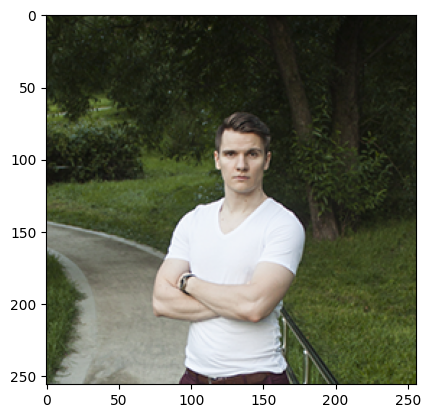

In [3]:
img = imageio.imread('me_256.png')
img = img.astype(np.float32) / 255
_=plt.imshow(img)

### Загрузка и подготовка карты сегментации человек/фон
То же самое касается файла 'me_gt_256.png'.

После загрузки мы приводим 3 канала RGB к одному каналу путём усреднения.

Это наша Ground-Truth карта сегментации, размеченная кем-то (мною) вручную.
Значение `'0'` в ней означает класс "фон", значение `'1'` -- класс "человек"

/tmp/ipykernel_219538/3752538407.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt = imageio.imread('me_gt_256.png')


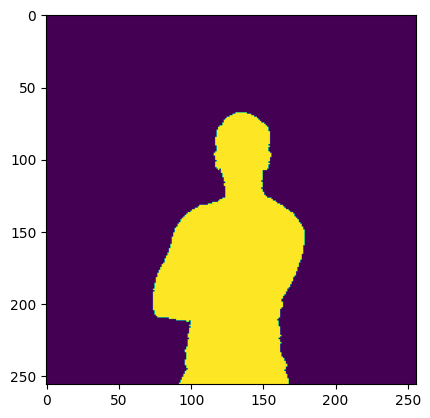

In [4]:
gt = imageio.imread('me_gt_256.png')
gt = gt.astype(np.float32) / 255.
gt = np.mean(gt, axis=2)[..., None]
_=plt.imshow(gt[...,0])

### Подготовка обучающего датасета
Наша цель создать и протестировать пайплайн для обучения FCN модели, включая данные, модель, лосс и т.д.

Поэтому для простоты эксперимента возьмем очень простой датасет, состоящий из двух изображений: загруженная картинка и её зеркально отраженная копия.

Индексирование `'::-1'` означает взять все элементы в обратном порядке.

При обучении на таком маленьком датасете модель переобучится, но в данном примере нас это не будет беспокоить. Наша цель - отладить пайплайн, поэтому тестировать будем на том же, на чём и обучались.

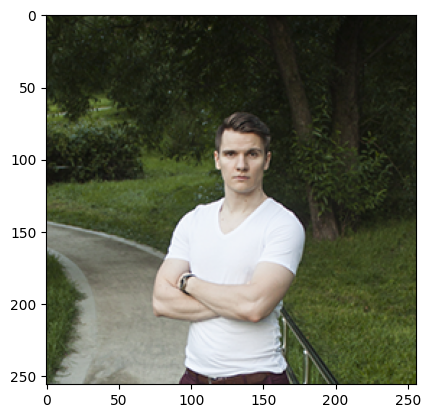

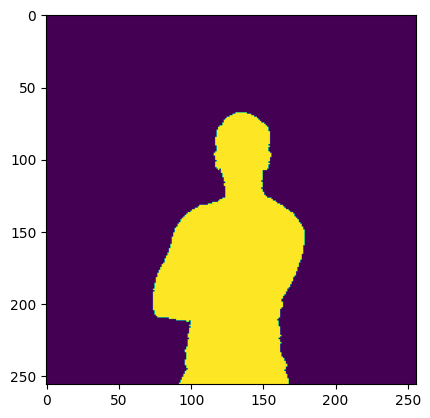

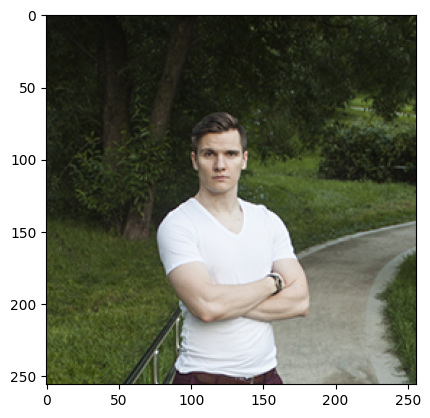

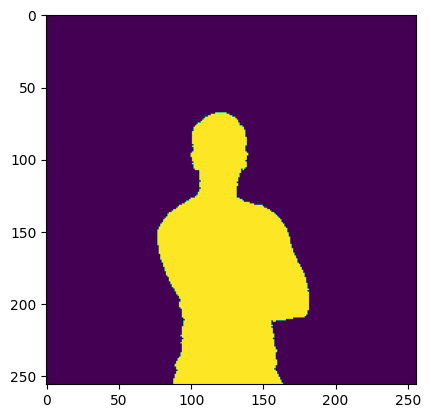

(<matplotlib.image.AxesImage at 0x782a753d53a0>, None)

In [5]:
train_x = np.stack((img, img[:,::-1,:]))
train_y = np.stack((gt, gt[:,::-1,:]))

plt.imshow(train_x[0]), plt.show()
plt.imshow(train_y[0][...,0]), plt.show()
plt.imshow(train_x[1]), plt.show()
plt.imshow(train_y[1][...,0]), plt.show()

# Пайплайн обучения FCN

### Создание FCN модели
В TensorFlow есть несколько способов создать нейросетевую модель. Ранее мы создавали модель с помощью `tf.keras.Sequential`, где нужно было просто перечислить последовательность слоёв. Кроме того, вы знакомы с функциональным способом создания модели, в котором мы строим наш вычислительных граф, соединяя различные операции, что даёт нам возможность получить произвольный граф из слоёв, а не только линейный (последовательный), как в случае Sequential.

Есть и третий способ создать модель -- создать свой собственный класс, наследованный от `tf.keras.Model`. Это самый гибкий способ, при таком подходе можно создавать абсолютно любые графы, в том числе динамические, то есть с произвольным потоком управления (control flow). В такой граф можно вставлять проверки условий, циклы и практически любые функции из Питона и TensorFlow.

Организовать такой класс мы можем произвольным образом, но как минимум нам надо реализовать конструктор `__init__()` и функцию для прямого распространения (инференса) нашего графа `call()`. В конструкторе мы создаём нужные нам слои и другие необходимые вещи. А в методе `call()` используем эти слои для вычисления прямого распространения (инференса) нашей сети. То есть именно в функции `call()` задается архитектура нашей нейронной сети путём написания кода в стиле обычного Питона.

Так как наш граф является динамическим и в TensorFlow мы включили режим жадного (eager) выполнения, написанный в функции `call()` код (то есть вычисления всех слоёв) будет выполняться прямо в момент вызова `call()` (не раньше и не позже), так же как и в обычном Питоне.

В результате вычисления слоёв (прохода по динамическому графу) нас интересуют две вещи. Первая вещь - финальный выход нейронной сети (то, что возвращает функция `call()`). Если нас не интересуют промежуточные данные (что было на выходе первого, второго слоя и.т.д) и эти тензоры больше нигде не используются, мы можем записывать выход каждого слоя в переменную с тем же именем (например, `out`) и передавать её на вход в следующий слой. Вторая вещь - запоминание пути, по которому шло прямое распространение, чтобы TensorFlow смог сделать backpropagation по "обратному" пути. Эта вторая вещь делается в TensorFlow автоматически, если мы используем так называемую градиентную ленту (Gradient Tape) или же используем функцию `fit()` из Keras для обучения модели (этот способ мы использовали ранее).

Созданный нами класс по сути то же является "слоем", так что мы можем использовать его как "слой" в каких-то других нейросетях. Таким образом можно создавать сложный нейронные сети модульно, сначала простые модели, а потом более сложные модули на их основе. Это нам пригодится в будущем. А пока что создадим довольно простую FCN с участием Свёрточных слоёв, Pooling слоёв и Upscale.

В качестве Upscale будем использовать билинейную интерполяцию. Для этого важно использовать функцию из TensorFlow (`tf.image.resize`), а не аналоги из Питона, чтобы для этой функции можно было посчитать backpropagation. В TensorFlow есть аналоги практически все математических и других питон функций, которые могут потребоваться при создании произвольных нейросетей.

**[ЗАДАНИЕ 1]** Вопрос: В конструкторе нашей модели мы создали отдельный экземпляр для каждого свёрточного слоя. А почему мы создали лишь один экземпляр Pooling слоя, несмотря на то, что в сети у нас есть несколько Pooling слоёв?

In [16]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.conv5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.conv7 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')
        self.conv8 = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation=None)
        self.pool = tf.keras.layers.MaxPool2D((2, 2))

    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.pool(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = tf.image.resize(out, (x.shape[1], x.shape[2]), tf.image.ResizeMethod.BILINEAR)
        out = tf.nn.sigmoid(out)
        return out

model = Model()

### Обучение FCN модели
В конце предыдущего блока мы создали объект `model` как экземпляр нашего класса `Model`.
Обучить такую модель теперь можно точно так же, как и любую другу модель в TensorFlow.

Так как на выходе в каждом пикселе у нас лишь одно значение (бинарная классификация "фон"/"человек"), то в сети в самом конце у нас использовалась функция `sigmoid`, выход которой в диапазоне от 0 до 1. Ground-Truth наш так же имеет одно значение в каждом пикселе (0 или 1).

Для обучения такой модели с таким Ground-Truth'ом нам понадобится вот такая лосс функция: `tf.keras.losses.BinaryCrossentropy()` (бинарная кросс-энтропия): https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

На выходе такой функции скаляр, так что если на входе был многомерный тензор, то автоматически происходит суммирование (reduce) по всем измерениям. Именно это нам и нужно для построения лосса для семантической сегментации.

**[ЗАДАНИЕ 2]** Реализуйте пайплайн обучения описанной выше модели `model`, как это делалось для других задач обучения в tensorFlow. Используйте созданные выше `train_x` и `train_y` в качестве обучающего датасета. Так как в обучающей выборке у нас всего два объекта, чтобы сеть обучалась подольше, возьмите побольше эпох, например 100. Постройте график зависимости лосса от эпохи.

In [17]:
%%time
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
hist = model.fit(train_x,train_y, epochs=100, batch_size=1)

Epoch 1/100


2024-05-04 13:45:47.641081: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-04 13:45:48.155856: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-04 13:45:48.155907: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-04 13:45:48.171967: W external/local_tsl/tsl/framework/bfc_

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5701 - loss: 0.6854
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8159 - loss: 0.6528
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8159 - loss: 0.5990
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8159 - loss: 0.5264
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8159 - loss: 0.3202
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8708 - loss: 0.2513
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8714 - loss: 0.2471
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8655 - loss: 0.2509
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8634 - loss: 0.2285
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8795 - loss: 0.2173
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8850 - loss: 0.2070
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8899 - loss: 0.1919
E

### Результат предсказания на входной картинке
Протестируем результат работы модели `model` на входной картинке `img`.

Не забудем приклеить дополнительное батч измерение с помощью `[None, ...]`, а потом отрезать его с помощью `[0, ...]`

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


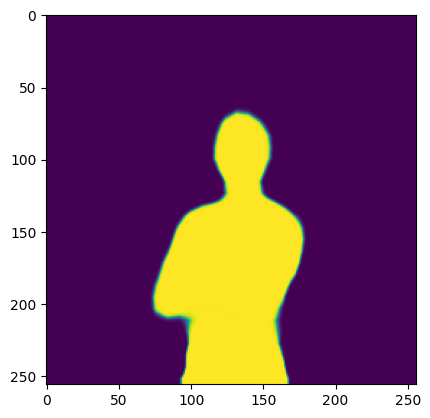

In [18]:
out = model.predict(img[None, ...])[0, ...]
_=plt.imshow(out[...,0])

### Результат предсказания для всех картинок
По непрерывному предсказанию FCN модели (от нуля до единицы) получим дискретную карту сегментации помощью порога (0.5).

Далее наложим полученную карту сегментации (после преобразования в цветную картинку с колормапом jet) на исходную картинку. Сделаем это для обоих объектов в обучающей выборке.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


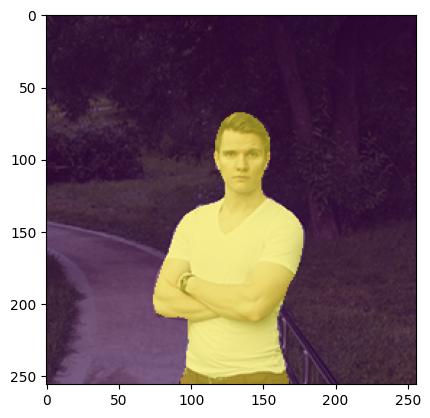

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


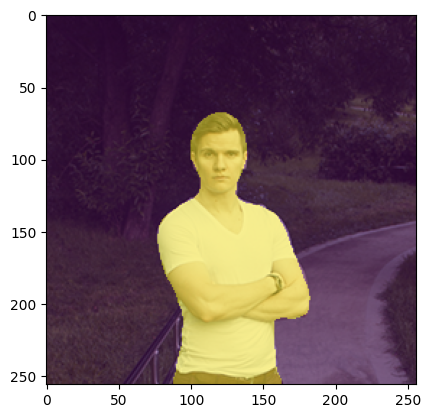

In [19]:
for sample in train_x:
    out = model.predict(sample[None, ...])
    seg_map = (out[0, ..., 0]>0.5).astype(np.float32)
    seg_map_clr = plt.get_cmap('viridis')(seg_map)[..., :3]
    plt.imshow(sample*0.5 + seg_map_clr*0.5)
    plt.show()

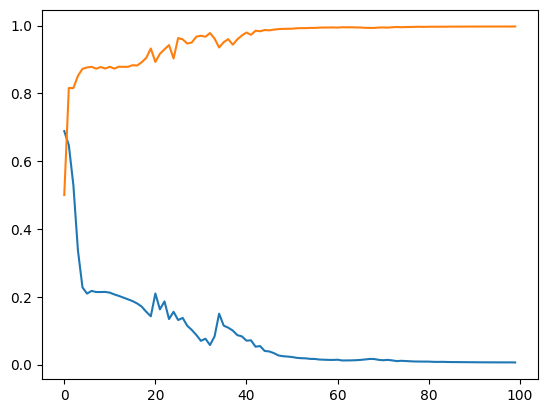

In [12]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['accuracy'])